In [1]:
import re, pprint

import parse
import pdfplumber
import pandas as pd

# Parsing DeleteMe Reports with PDFPlumber

PDFPlumber is really nice, but not sufficient for extracting all the data we need due to the PDF structure. For getting basic data out it's really good.

In [2]:
fn = './privacy-report.pdf'

In [3]:
with pdfplumber.open(fn) as pdf:
    pages = pdf.pages
    # There's a weird thing where it's easier to do text extraction as the file is read
    for page in pages:
        print(f"Processing page: {page.page_number}")
        text = page.extract_text()

Processing page: 1
Processing page: 2
Processing page: 3
Processing page: 4
Processing page: 5
Processing page: 6
Processing page: 7
Processing page: 8
Processing page: 9
Processing page: 10
Processing page: 11
Processing page: 12


In [4]:
p2 = pdf.pages[2] # Starts from 0
p2list = p2.extract_text().split('\n')
p2list

["KATASHA'S TRIAL ACCOUNTS Privacy Protection Program May 2024",
 'May 2024 Report',
 "KATASHA'S TRIAL ACCOUNTS Privacy Program With Last Scan",
 'Friday, May 31, 2024',
 'DeleteMe Detects And Removes Your Personal Info',
 'When It Is Found Exposed.',
 'Your DeleteMe Business Protection Plan: Activated Date: Dashboard Login:',
 'Gold Diamond Platinum VIP 11/29/2023 joindeleteme.com',
 '3,962 2 2 10',
 'Total listings Total listings Data brokers with Total PII Found',
 'reviewed removed your personal info',
 'Time Saved Searching: Time Saved Removing:',
 'About 45 ½ hours About 9 ½ hours',
 'Endole was the data broker with the most info on you',
 'TOTAL LISTINGS REVIEWED TOTAL LISTINGS REMOVED',
 '4139 4098 4098 3962 7',
 '4',
 '3',
 '2',
 "Feb'24 Mar'24 May'24 May'24 Feb'24 Mar'24 May'24 May'24",
 'Listings reviewed include total unique searches and results Listings removed are removals and opt-out submissions',
 'returned that are analyzed by the DeleteMe platform and made to one or m

In [5]:
# Page 2 Extractor
p2 = pdf.pages[2]
p2list = p2.extract_text().split('\n')
report_date = p2list[3]
listings = p2list[8].split(' ')
summary = {
    'total_listings_reviewed': listings[0].replace(',',''),
    'total_listings_removed': listings[1],
    'brokers_with_pii': listings[2],
    'total_pii_found': listings[3]
}
data = {
    'report_date': report_date,
    'summary': summary,
}

pprint.pp(data)

{'report_date': 'Friday, May 31, 2024',
 'summary': {'total_listings_reviewed': '3962',
             'total__listings_removed': '2',
             'brokers_with_pii': '2',
             'total_pii_found': '10'}}


In [98]:
# Extract Page 3
p3 = pdf.pages[3]
results = p3.extract_text().replace(',','').split('\n')
r = results[2].split(' ')
google_scan = {
    'results_reviewed': r[0],
    'opt_outs_sent': r[1],
    'not_user': r[2],
}
data['google_scan_exposure_findings'] = google_scan
data

{'report_date': 'Friday, May 31, 2024',
 'summary': {'total_listings_reviewed': '3962',
  'total__listings_removed': '2',
  'brokers_with_pii': '2',
  'total_pii_found': '10'},
 'google_scan_exposure_findings': {'results_reviewed': '3232',
  'opt_outs_sent': '4',
  'not_user': '3215'}}

In [99]:
# Extract Page 4
p4 = pdf.pages[5]
in_progress, repeat_listings, new_listings, clean = p4.extract_text().replace(',','').split('\n')[2].split(' ')
findings = {
    'in_progress': in_progress,
    'repeat_listings': repeat_listings,
    'new_listings': new_listings,
    'clean': clean,
}
data['findings'] = findings
data

{'report_date': 'Friday, May 31, 2024',
 'summary': {'total_listings_reviewed': '3962',
  'total__listings_removed': '2',
  'brokers_with_pii': '2',
  'total_pii_found': '10'},
 'google_scan_exposure_findings': {'results_reviewed': '3232',
  'opt_outs_sent': '4',
  'not_user': '3215'},
 'findings': {'in_progress': '2',
  'repeat_listings': '0',
  'new_listings': '0',
  'clean': '46'}}

## Bounding Boxes
Rather than extracting lines, we can use bounding boxes. This allows us to restrict OCR efforts to particular parts of the page.
The last page contains advisor-created requests. We can extract the values without risking data from the rest of the page getting in.

Bounding boxes are a tuple with the following parameters, in order:

- x0 - Left edge
- y0 - Top edge
- x1 - Right edge
- y1 - Bottom edge

The values are stored in dots, normaly 72 dpi by default.

A `page` object has `.width` and `.height` settings. The easiest way to identify a bounding box using Jupyter is to convert the bounding box area to an image, and render it inline.

In [117]:
# Page -1 (last page)
pminusone = pdf.pages[-1]

x0 = 40
y0 = 150
x1 = pminusone.width # We use this because we don't know how big the number might get
y1 = 180

bounding_box = (x0, y0, x1, y1)
crop_area = pminusone.crop(bounding_box)
crop_area.to_image()

### Extracting The Data

Now we have the crop area we can extract the data without needing fancy line splitting tricks.

In [118]:

pmolist = crop_area.extract_text().replace(',','')
removal_requests, investigating, cant_remove, removed = pmolist.split(' ')

advisor_stats = {
    'removal_requests': removal_requests,
    'investigating': investigating,
    'cant_remove': cant_remove,
    'removed': removed,
}
data['advisor_stats'] = advisor_stats
data

{'report_date': 'Friday, May 31, 2024',
 'summary': {'total_listings_reviewed': '3962',
  'total__listings_removed': '2',
  'brokers_with_pii': '2',
  'total_pii_found': '10'},
 'google_scan_exposure_findings': {'results_reviewed': '3232',
  'opt_outs_sent': '4',
  'not_user': '3215'},
 'findings': {'in_progress': '2',
  'repeat_listings': '0',
  'new_listings': '0',
  'clean': '46'},
 'advisor_stats': {'removal_requests': '1',
  'investigating': '0',
  'cant_remove': '0',
  'removed': '1'}}

## Extracting Report Findings

The report findings section is a multi-page report that ends on the last page but one. We want to ensure we extract all the info for onward processing. The first page contains a table at the top that we're not interested in, so we'll use a bounding box for that page.

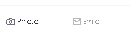

In [347]:
pages = pdf.pages[6:-2]
start_page = pdf.pages[5]
x0 = start_page.width - 180
y0 = 280
x1 = start_page.width - 50# We use this because we don't know how big the number might get
y1 = start_page.height - 480

bounding_box = (x0, y0, x1, y1)
crop_area = start_page.crop(bounding_box)
img = crop_area.to_image()
#img.draw_rects(crop_area.extract_words())
img.original

In [348]:
il = crop_area.rects
print(len(il))
#img.draw_rects(il)
#crop_area.to_image()
dir(img.page.chars)
[x for x in il if x['stroking_color'] == (0.1882, 0.5529, 0.2667)]
cols = list(set([x['stroking_color'] for x in il]))
cols

4


[(0, 0, 0), (0.9569, 0.9569, 0.9569), (1, 1, 1)]

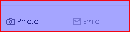

In [343]:
tgt = [x for x in il if x['stroking_color'] == cols[2]]
i = crop_area.to_image()
i.draw_rects(tgt)

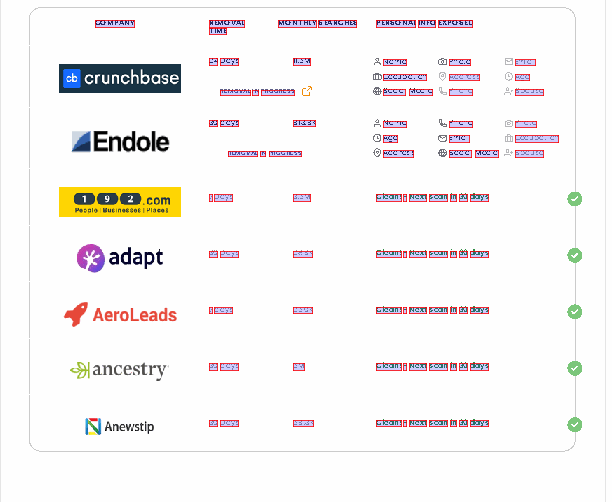

In [257]:
len(crop_area.rects)
i = crop_area.to_image()
i.draw_rects(crop_area.extract_words())

In [357]:
import pymupdf
from PIL import Image

In [378]:
doc = pymupdf.open(fn)
doc.page_count

12

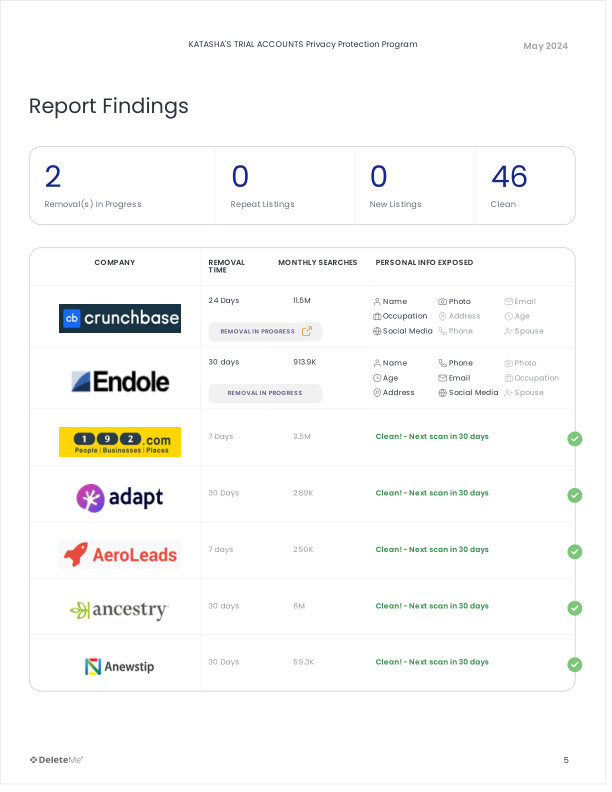

In [358]:
page = doc[5]
links = page.get_links()
pix = page.get_pixmap()
mode = "RGBA" if pix.alpha else "RGB"
img = Image.frombytes(mode, [pix.width, pix.height], pix.samples)
img

In [371]:
text_blocks = page.get_text("dict", flags=pymupdf.TEXTFLAGS_TEXT)["blocks"]
for block in text_blocks:
    for line in block["lines"]:
        for span in line["spans"]:
            text = span["text"]
            color = pymupdf.sRGB_to_rgb(span["color"])
            if text == "Photo":
                print(f"Text: {text}, Color: {color}")

Text: Photo, Color: (45, 50, 61)
Text: Photo, Color: (45, 50, 61)


In [408]:
# Lets get report date
page = doc[2]
rect = (500, 130, 600, 140)
report_date = page.get_textbox(rect)
print(report_date)

Friday, May 31, 2024


In [42]:
page = doc[2]
rect = (0, 250, 600, 280)
listings = doc[2].get_textbox(rect).split('\n')

#p2list = p2.extract_text().split('\n')
#report_date = p2list[3]
#listings = p2list.split(' ')
summary = {
    'total_listings_reviewed': listings[0].replace(',',''),
    'total__listings_removed': listings[1],
    'brokers_with_pii': listings[2],
    'total_pii_found': listings[3]
}
data = {
    'report_date': report_date,
    'summary': summary,
}
data

NameError: name 'doc' is not defined